# Simulome experiments

Author: Jake Bradford

This notebook is for tracking experiments of Simulome.

In [1]:
import os
import subprocess
import functools

from glob import glob

import helpers

import pandas as pd
import matplotlib.pyplot as plt

# Simulome in Docker

I have setup a Docker container that has Simulome and BLAST installed.

## Dockerfile

In [51]:
!cat dockerfile-simulome

FROM python:2.7

RUN \
    git clone https://github.com/price0416/Simulome.git && \
    cd Simulome && \
    git checkout d19ca0643c172e9e5ab80137189f5a1f74dd4445 

RUN pip install numpy==1.11.0 biopython==1.61

RUN wget https://ftp.ncbi.nlm.nih.gov/blast/executables/blast+/2.3.0/ncbi-blast-2.3.0+-x64-linux.tar.gz

RUN tar -xvzf ncbi-blast-2.3.0+-x64-linux.tar.gz

ENV PATH="$PATH:/ncbi-blast-2.3.0+/bin/"

RUN wget https://ftp.gnu.org/gnu/time/time-1.9.tar.gz

RUN tar -xvzf time-1.9.tar.gz

WORKDIR "/time-1.9/"

RUN ./configure

RUN make install 


## Building the Docker image

```bash
docker build --no-cache -t simulome-img -f dockerfile-simulome .
```

## Interactive session with this container

```bash
docker run -v /home/jake/genome-sim-benchmark/ncbi_dataset:/ncbi_dataset -v /home/jake/genome-sim-benchmark/results-simulome:/results-simulome --name simulome-container -it simulome-img /bin/bash
```

## Run a test experiment

**This command is explained below**

```bash
docker run -v /home/jake/genome-sim-benchmark/ncbi_dataset:/ncbi_dataset -v /home/jake/genome-sim-benchmark/results-simulome-test1:/results-simulome --rm -w /Simulome simulome-img python simulome.py --genome=/ncbi_dataset/data/GCF_002157895.1/GCF_002157895.1_ASM215789v1_genomic.fna --output=/results-simulome --anno=/ncbi_dataset/data/GCF_002157895.1/genomic.gff
```

Mount two volumes:
    
    1. `-v`: `/home/jake/genome-sim-benchmark/ncbi_dataset:/ncbi_dataset`
    
    2. `-v`: `/home/jake/genome-sim-benchmark/results-simulome-test1:/results-simulome`
    
`--rm`: Remove the container when done 

`-w`: set the working directory to `/Simulome`

Use the image named `simulome-img`

Execute a command: `python simulome.py --genome=/ncbi_dataset/data/GCF_002157895.1/GCF_002157895.1_ASM215789v1_genomic.fna --output=/results-simulome --anno=/ncbi_dataset/data/GCF_002157895.1/genomic.gff`

# Simulome

## Help documentation

To capture the help documentation, I ran the following command:



```bash
docker run -v /home/jake/genome-sim-benchmark/ncbi_dataset:/ncbi_dataset -v /home/jake/genome-sim-benchmark/results-simulome-test1:/results-simulome --rm -w /Simulome simulome-img python simulome.py --help > simulome-help.txt
```

In [7]:
!cat simulome-help.txt

Usage: simulome.py --genome=<genome.fasta> -anno=<genome.gff> -output=<destination> <RUN MODE ARGUMENTS> <OPTIONAL ARGUMENTS>

Options:
  -h, --help            show this help message and exit

  Required Arguments:
    --genome=GENOME_FILE
                        File representing genome. FASTA nucleotide format.
    --anno=ANNO_FILE    File containing genome annotation information in
                        GTF/GFF3 format.
    --output=PREFIX     Creates a folder named with the supplied prefix
                        containing output files.

  SNP Run Mode:
    --snp=SNP_MODE      Mutated genome will contain SNPs. TRUE/FALSE.
    --num_snp=NUM_SNP   The number of SNPs to simulate in each gene. Required
                        for SNP mode. If --snp_distribute is turned on, this
                        value will become the mean of a gaussian distribution
                        from which number of SNPs per gene will be drawn.
    --snp_window=SNP_WINDOW
                        Wind

## Code review

Some comments:

- The parsing of command line arguments is extensive. I can see that each mutation mode is not exclusive of each other. The user can specify arguments such that multiple modes are applied. Importantly, the implementation dicates a fixed order of operations, being:
    1. Apply deletions (line 2165)
    2. Apply insertions (line 2180)
    3. Apply SNPs (line 2195)
    4. Apply synonymous mutations (line 2222)
    5. Apply duplications (line 2229)
- By default, all annotated genes are considered. The user can specify `--num_genes` which helps select a set of random genes.

# Experiments

## Does the flag `--seed` behave as expected?

First, run two different simulations (SNP rates 20 and 22).

Then, run a third experiment which is identical to the first (SNP rate 20).

In [98]:
!docker run -v /home/jake/genome-sim-benchmark/ncbi_dataset:/ncbi_dataset -v /home/jake/genome-sim-benchmark/results-simulome-seed01:/results-simulome --rm -w /Simulome simulome-img python simulome.py --genome=/ncbi_dataset/data/GCF_002157895.1/GCF_002157895.1_ASM215789v1_genomic.fna --output=/results-simulome --anno=/ncbi_dataset/data/GCF_002157895.1/genomic.gff --snp=TRUE --num_snp=20 --seed=2024

	Writing annotation file: /results-simulome//results-simulome_simulated.gff
	Writing FASTA file: /results-simulome//results-simulome_simulated.fasta
	Writing annotation file: /results-simulome//results-simulome_mutated_simulation.gff
	Writing FASTA file: /results-simulome//results-simulome_mutated_simulation.fasta
	Writing mutation log file: /results-simulome//results-simulome_mutations.log
Process Complete.


In [99]:
!docker run -v /home/jake/genome-sim-benchmark/ncbi_dataset:/ncbi_dataset -v /home/jake/genome-sim-benchmark/results-simulome-seed02:/results-simulome --rm -w /Simulome simulome-img python simulome.py --genome=/ncbi_dataset/data/GCF_002157895.1/GCF_002157895.1_ASM215789v1_genomic.fna --output=/results-simulome --anno=/ncbi_dataset/data/GCF_002157895.1/genomic.gff --snp=TRUE --num_snp=22 --seed=2024

	Writing annotation file: /results-simulome//results-simulome_simulated.gff
	Writing FASTA file: /results-simulome//results-simulome_simulated.fasta
	Writing annotation file: /results-simulome//results-simulome_mutated_simulation.gff
	Writing FASTA file: /results-simulome//results-simulome_mutated_simulation.fasta
	Writing mutation log file: /results-simulome//results-simulome_mutations.log
Process Complete.


In [107]:
!docker run -v /home/jake/genome-sim-benchmark/ncbi_dataset:/ncbi_dataset -v /home/jake/genome-sim-benchmark/results-simulome-seed03:/results-simulome --rm -w /Simulome simulome-img python simulome.py --genome=/ncbi_dataset/data/GCF_002157895.1/GCF_002157895.1_ASM215789v1_genomic.fna --output=/results-simulome --anno=/ncbi_dataset/data/GCF_002157895.1/genomic.gff --snp=TRUE --num_snp=20 --seed=2024

	Writing annotation file: /results-simulome//results-simulome_simulated.gff
	Writing FASTA file: /results-simulome//results-simulome_simulated.fasta
	Writing annotation file: /results-simulome//results-simulome_mutated_simulation.gff
	Writing FASTA file: /results-simulome//results-simulome_mutated_simulation.fasta
	Writing mutation log file: /results-simulome//results-simulome_mutations.log
Process Complete.


**Check that the first two differ (they should)**

The `diff` command with flag `-q` will simply report that the files differ, if they do.

In [102]:
!diff /home/jake/genome-sim-benchmark/results-simulome-seed01/results-simulome_mutated_simulation.fasta /home/jake/genome-sim-benchmark/results-simulome-seed02/results-simulome_mutated_simulation.fasta -q

Files /home/jake/genome-sim-benchmark/results-simulome-seed01/results-simulome_mutated_simulation.fasta and /home/jake/genome-sim-benchmark/results-simulome-seed02/results-simulome_mutated_simulation.fasta differ


In [106]:
!diff /home/jake/genome-sim-benchmark/results-simulome-seed01/results-simulome_mutations.log /home/jake/genome-sim-benchmark/results-simulome-seed02/results-simulome_mutations.log -q

Files /home/jake/genome-sim-benchmark/results-simulome-seed01/results-simulome_mutations.log and /home/jake/genome-sim-benchmark/results-simulome-seed02/results-simulome_mutations.log differ


**Check that the last two differ (they should not)**

In [109]:
!diff /home/jake/genome-sim-benchmark/results-simulome-seed01/results-simulome_mutated_simulation.fasta /home/jake/genome-sim-benchmark/results-simulome-seed03/results-simulome_mutated_simulation.fasta -q

In [110]:
!diff /home/jake/genome-sim-benchmark/results-simulome-seed01/results-simulome_mutations.log /home/jake/genome-sim-benchmark/results-simulome-seed03/results-simulome_mutations.log -q

**How many mutations?**

In [101]:
!wc -l /home/jake/genome-sim-benchmark/results-simulome-seed01/results-simulome_mutations.log
!wc -l /home/jake/genome-sim-benchmark/results-simulome-seed02/results-simulome_mutations.log

1921 /home/jake/genome-sim-benchmark/results-simulome-seed01/results-simulome_mutations.log
2113 /home/jake/genome-sim-benchmark/results-simulome-seed02/results-simulome_mutations.log


## Try measuring run time

Here, the intention is to try measuring the run-time of Simulome. Afterwards, the runtime of all experiments will be measured.

We will use the `GNU time` command along with some formatting options to capture its output in CSV format. Here's a command that should do the job:

```bash
/usr/bin/time -f "%e,%U,%S,%P,%K,%M,%F,%R,%W,%c,%w" -o output.csv your_command_here
```

This command will run your command (`your_command_here`) and capture various resource usage details into a CSV file named `output.csv`. Each column in the CSV file represents a different resource usage metric, such as real time (`%e`), user CPU time (`%U`), system CPU time (`%S`), and so on.

Here's a breakdown of the formatting options used:

- `%e`: Elapsed real time (in seconds).
- `%U`: Total user CPU time (in seconds).
- `%S`: Total system CPU time (in seconds).
- `%P`: Percentage of the CPU that this job got, computed as (%U + %S) / %E.
- `%K`: Average total (data+stack+text) memory usage (in kilobytes).
- `%M`: Maximum resident set size of the process during its lifetime (in kilobytes).
- `%F`: Number of major page faults that occurred while the process was running.
- `%R`: Number of minor, or recoverable, page faults. These are pages that are not valid (so they fault) but which have not yet been claimed by other virtual pages. Thus the data in the page is still valid but the system tables must be updated.
- `%W`: Number of times the process was swapped out of main memory.
- `%c`: Number of times the process was context-switched involuntarily (because the time slice expired).
- `%w`: Number of waits: times that the program was context-switched voluntarily, for instance while waiting for an I/O operation to complete.

Replace `your_command_here` with the command you want to execute and capture details for. After running the command, you'll find the output details in the `output.csv` file.

In [64]:
!docker run -v /home/jake/genome-sim-benchmark/ncbi_dataset:/ncbi_dataset -v /home/jake/genome-sim-benchmark/results-simulome-test-measure-time:/results-simulome --rm -w /Simulome simulome-img /usr/local/bin/time -f "%e,%U,%S,%P,%K,%M,%F,%R,%W,%c,%w" -o "/results-simulome/time.txt" python simulome.py --genome=/ncbi_dataset/data/GCF_002157895.1/GCF_002157895.1_ASM215789v1_genomic.fna --output=/results-simulome --anno=/ncbi_dataset/data/GCF_002157895.1/genomic.gff --seed=2024

docker: Error response from daemon: failed to create task for container: failed to create shim task: OCI runtime create failed: runc create failed: unable to start container process: exec: "-c": executable file not found in $PATH: unknown.


## 1. Number of SNPs

Vary the SNP settings and measure with `time`

As per the source code, the `--num_snp` parameter is expected to be a positive, non-zero digit:

```python
# https://github.com/price0416/Simulome/blob/master/simulome.py#L1591

if not options.num_snp.isdigit() or int(options.num_snp) <= 0:
    print "Number of SNPs must be an integer greater than 0."
    sys.exit()
```                

That value is used from line 826:

```python
# https://github.com/price0416/Simulome/blob/master/simulome.py#L1591

#Randomly mutate positions in the target window until the desired number of SNPs is achieved.
while numMutated < numSNP:
    for j in range(len(windowSeq)):
        mutateChance = random.randint(0,windowLen)
        if mutateChance <= numSNP:
            #Don't mutate the same position twice.
            if windowBitMask[j] == 1:
                continue
            newBase = mutateBase(windowSeq[j])
            absoluteStartPos = curStart + j

            if isVerbose == 2:
                print "\tAbsolute position: " + str(curStart + j)
                print "\tRelative position: " + str(j)
                print "\t\tSNP: " + windowSeq[j] + " => " + newBase

            #Log the mutation.
            mutation_log.append([absoluteStartPos, absoluteStartPos+1, "SNP", windowSeq[j], newBase, mutation_count])
            mutation_count = mutation_count + 1

            windowSeq = windowSeq[:j] + newBase + windowSeq[j+1:]
            windowBitMask[j] = 1
            numMutated = numMutated + 1
            if numMutated >= numSNP:
                break
```                    

### Run

In [ ]:
for snp in [1] + list(range(5, 205, 5)):
    for dir in glob("ncbi_dataset/data/*"):
        if os.path.isdir(dir):
            fna = glob(f"{dir}/*.fna")[0]
            gff = glob(f"{dir}/*.gff")[0]
            accession = os.path.basename(dir)
            
            output_dir = f'/home/jake/genome-sim-benchmark/results-simulome/num-snps/{accession}/{snp}'
            
            if not os.path.exists(output_dir):
                os.makedirs(output_dir)
            else:
                continue
            
            cmd = [
                # Docker commands
                'docker', 'run',
                '-v', '/home/jake/genome-sim-benchmark/ncbi_dataset:/ncbi_dataset',
                '-v', f'{output_dir}:/results-simulome',
                '--rm',
                '-w', '/Simulome',
                'simulome-img',
    
                # GNU time
                '/usr/local/bin/time',
                '-f', '%e,%U,%S,%P,%K,%M,%F,%R,%W,%c,%w',
                '-o', '/results-simulome/time.txt',
                
                # Simulome script
                'python', 'simulome.py',
                f'--genome=/{fna}',
                '--output=/results-simulome',
                f'--anno=/{gff}',
                '--snp=TRUE',
                f'--num_snp={snp}',
                '--seed=2024',
                '--verbose=2'
            ]

            with open(f'{output_dir}/readme.md', 'w') as fp:
                fp.write(' '.join(cmd))
                
            print(' '.join(cmd), '\n'*3)

            with open(f'{output_dir}/stdout.log', 'w') as stdout, open(f'{output_dir}/stderr.log', 'w') as stderr:
                try:
                    process = subprocess.run(
                        cmd, 
        
                        # capture standard streams
                        stdout=stdout,
                        stderr=stderr, 
        
                        # timeout after 3 minutes
                        timeout=3*60
                    )
                except Exception as e:
                    stderr.write(f'{e}')
                    pass

### Analysis

**Note:** In this experiment, I am separating visualisations away from data preparation and analysis.

#### Calculate ANI

In [36]:
for fna in glob("/home/jake/genome-sim-benchmark/ncbi_dataset/data/*/*.fna"):
    accession = fna.split('/')[-2]
    
    for dir in glob(f"/home/jake/genome-sim-benchmark/results-simulome/num-snps/{accession}/*"):
        snp = os.path.basename(dir)

        mutated_fa = glob(f'{dir}/*mutated*.fasta')
        if len(mutated_fa) != 1:
            continue
            
        mutated_fa = mutated_fa[0]

        fastani_output = f'{dir}/fastani.txt'

        if os.path.exists(fastani_output):
            continue
        
        cmd = [
            '/opt/FastANI-v1.34/fastANI',

            # reference sequence
            '-r', fna,

            # query sequence
            '-q', mutated_fa,

            # output file
            '-o', fastani_output
        ]
        
        subprocess.run(cmd, stderr=subprocess.DEVNULL)

#### Extract data

In [ ]:
output_dir = f'/home/jake/genome-sim-benchmark/results-simulome/num-snps/'
data = []
time_keys = ['real_time', 'user_cpu_time', 'system_cpu_time', 'cpu_percentage',
    'average_total_memory', 'maximum_resident_set_size', 'page_faults',
    'reclaimed_pages', 'swaps', 'context_switches_voluntary',
    'context_switches_involuntary']
        
for accession_dir in glob(f'{output_dir}/*'):
    accession = os.path.basename(accession_dir)

    for snp_dir in glob(f'{accession_dir}/*'):
        snp = float(os.path.basename(snp_dir))

        # read in `time` results
        with open(f'{snp_dir}/time.txt', 'r') as fp:
            time_values = [x.replace('%', '').strip() for x in fp.readline().split(',') if len(x) > 0]

        time_data = {}

        for key, value in zip(time_keys, time_values):
            time_data[key] = value.replace('%', '').strip()

        # load ANI data
        fastani_data = {}
        try:
            with open(f'{snp_dir}/fastani.txt', 'r') as fp:
                fields = fp.readline().strip().split('\t')
                fastani_data = {
                    'ani' : float(fields[-3]),
                    'ref_frags' : float(fields[-2]),
                    'query_frags' : float(fields[-1]),
                }
        except Exception as e:
            print(f'Error with ANI results: {snp_dir}')
            pass


        # metadata
        metadata = {
            'accession' : accession,
            'snp' : snp,  
        }

        
        # merge results
        data.append(metadata | time_data | fastani_data)

df = pd.DataFrame(data)
print(df.columns)
for key in keys:
    df[key] = pd.to_numeric(df[key])

df['length'] = df['accession'].apply(helpers.get_assembly_length)

df

### Plot

#### Time versus number of SNPs

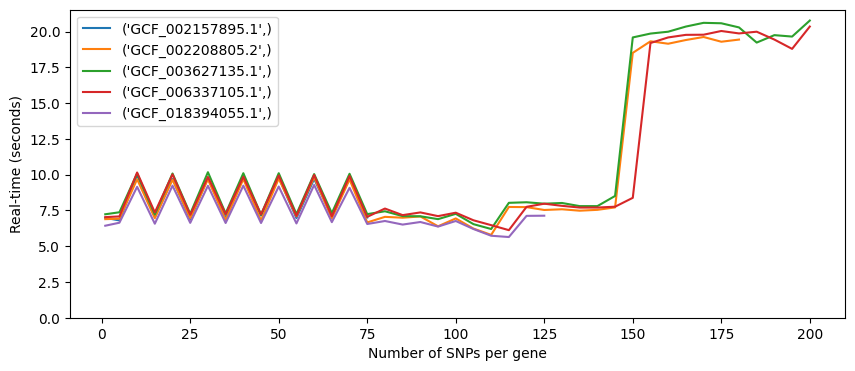

In [92]:
fig, ax = plt.subplots(figsize=(10,4))
for key, grp in df.groupby(['accession']):
    grp = grp.sort_values('snp')
    #print(key, '\n', grp[['snp', 'real_time']], '\n\n',)
    ax.plot(grp['snp'], grp['real_time'], label=key)
ax.set_ylim(ymin=0)
ax.set_xlabel('Number of SNPs per gene')
ax.set_ylabel('Real-time (seconds)')
ax.legend()
plt.show()

#### Time versus sequence length

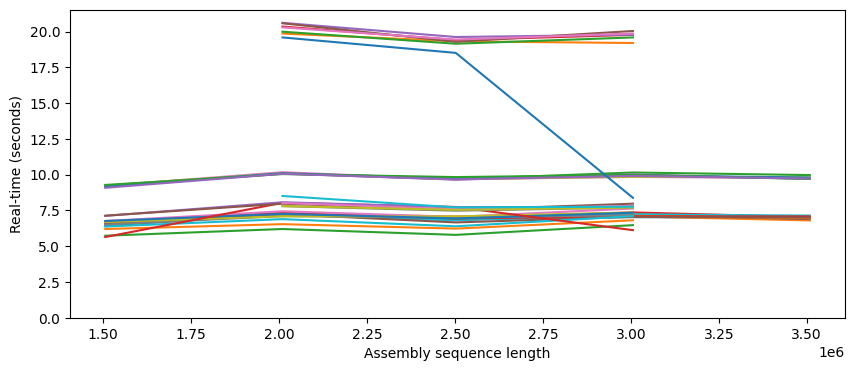

In [97]:
fig, ax = plt.subplots(figsize=(10,4))
for key, grp in df.groupby(['snp']):
    grp = grp.sort_values('length')
    #print(key, '\n', grp[['snp', 'real_time']], '\n\n',)
    ax.plot(grp['length'], grp['real_time'], label=key)
ax.set_ylim(ymin=0)
ax.set_xlabel('Assembly sequence length')
ax.set_ylabel('Real-time (seconds)')
plt.show()

#### ANI versus number of SNPs

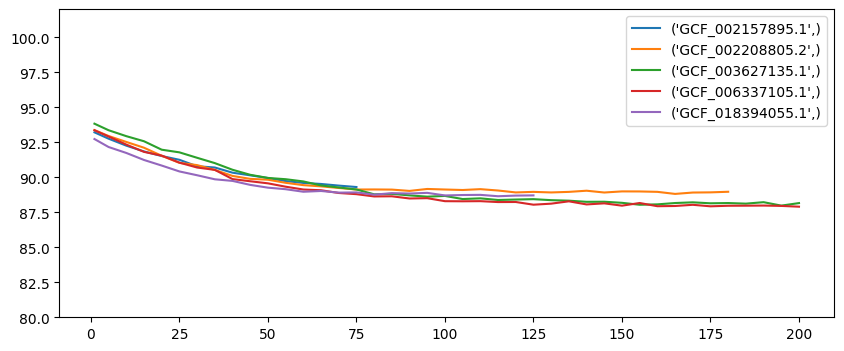

In [99]:
fig, ax = plt.subplots(figsize=(10,4))
for key, grp in df.groupby(['accession']):
    grp = grp.sort_values('snp')
    ax.plot(grp['snp'], grp['ani'], label=key)
ax.set_ylim(ymin=80, ymax=102)
ax.legend()
plt.show()

#### Location of mutations

/home/jake/genome-sim-benchmark/results-simulome/num-snps/GCF_018394055.1/5/results-simulome_mutations.log GCF_018394055.1
/home/jake/genome-sim-benchmark/results-simulome/num-snps/GCF_006337105.1/5/results-simulome_mutations.log GCF_006337105.1
/home/jake/genome-sim-benchmark/results-simulome/num-snps/GCF_002157895.1/5/results-simulome_mutations.log GCF_002157895.1
/home/jake/genome-sim-benchmark/results-simulome/num-snps/GCF_002208805.2/5/results-simulome_mutations.log GCF_002208805.2
/home/jake/genome-sim-benchmark/results-simulome/num-snps/GCF_003627135.1/5/results-simulome_mutations.log GCF_003627135.1


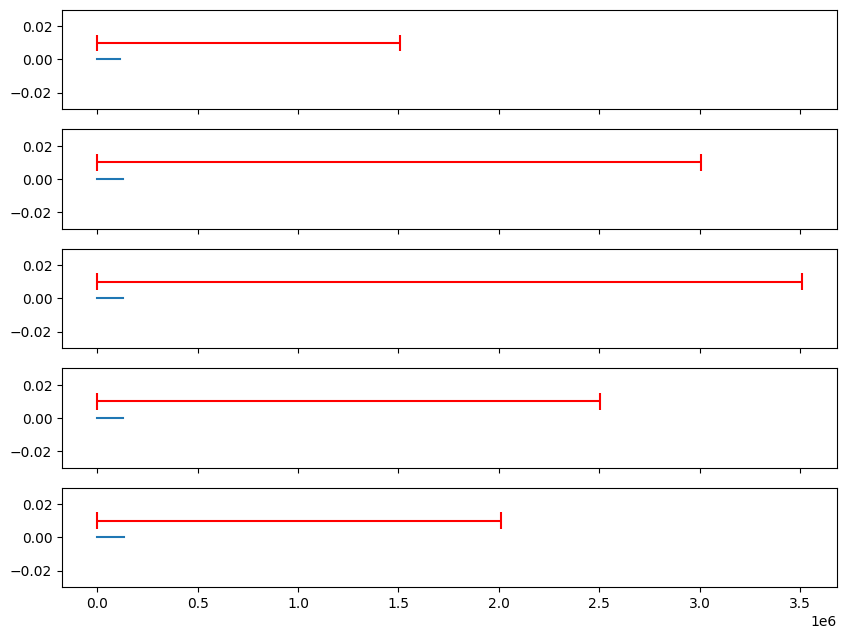

In [154]:
results = glob('/home/jake/genome-sim-benchmark/results-simulome/num-snps/*/5/results-simulome_mutations.log')[0:10]
fig, axes = plt.subplots(nrows=len(results), ncols=1, figsize=(10,1.5*len(results)), sharex=True)
for idx, result in enumerate(results):
    df = pd.read_csv(result, sep='\t')
    accession = [x for x in result.split('/') if 'GCF' in x][0]
    print(result, accession)
    ax = axes[idx]
    ax.plot(df['START'], [0] * len(df))
    ax.hlines(0.01, 0, helpers.get_assembly_length(accession), colors='r')
    ax.vlines([0, helpers.get_assembly_length(accession)], 0.005, 0.015, colors='r')
    ax.set_ylim(ymin=-0.03, ymax=0.03)
#ax.legend()
plt.show()

## 2. Number of SNPs in a subset of genes

As per line 1944, we must specify a reasonable number of genes to mutate:

```python
if len(anno_subset) <= desired_gene_count:
```

- `anno_subset` is a filtered list of the annotations. By default, this list would be all `gene` features.

- `desired_gene_count` is CLI argument `--num_genes`

- The comparative operator is `<=` which prevents mutating every gene in the genome. I believe the comparative operator should actually be `<`.

The genes are selected based on their lengths (line 1953):

```python
#Select the proper number of genes in a normal distribution around their lengths.
```

If `--num_genes` is not specified then it defaults to 100.


### Run

In [3]:
helpers.get_feature_count_all_accessions()

{'GCF_018394055.1': 1570,
 'GCF_006337105.1': 2832,
 'GCF_002157895.1': 3050,
 'GCF_002208805.2': 2354,
 'GCF_003627135.1': 1907}

In [ ]:
max_time = 15*60 # max run-time in seconds

for dir in glob("ncbi_dataset/data/*"):

    if not os.path.isdir(dir):
        continue
        
    accession = os.path.basename(dir)

    max_num_genes = helpers.get_feature_count_by_accession(accession, feature='gene')
      
    # RE mutate all genes: in the Simulome source, desired_gene_count is incremented 
    #   by one and the comparative operator is incorrect, so the num_genes flag 
    #   should be decremented by two to account for this.
    #for num_genes in [1] + list(range(100, max_num_genes+150, 100)) + [max_num_genes-2]:
    for num_genes in [max_num_genes-2]:
        
        for num_snp in range(1, 6, 1):
            
            if os.path.isdir(dir):
                fna = glob(f"{dir}/*.fna")[0]
                gff = glob(f"{dir}/*.gff")[0]
                accession = os.path.basename(dir)
                
                output_dir = f'/home/jake/genome-sim-benchmark/results-simulome/num-snps-num-genes/{accession}/{num_snp}-{num_genes}'
                
                if not os.path.exists(output_dir):
                    os.makedirs(output_dir)

                run_experiment = True

                # Check if the experiment should be skipped because it previously timed-out
                stderr_path = os.path.join(output_dir, 'stderr.log')
                if os.path.exists(stderr_path):
                    
                    with open(stderr_path, 'r') as fp:
                        line = fp.readline().strip()
                        
                    if 'timed out after' in line:
                        previous_time = float(line.split(' ')[-2])

                        # allow a 5 second margin
                        if (max_time - previous_time) < 5:
                            print(f'previously attempted and cancelled after {previous_time}')
                            run_experiment = False
                    else:
                        print('This experiment ran successfully')
                        run_experiment = False
                        
                if not run_experiment:
                    continue

                cmd = [
                    # Docker commands
                    'docker', 'run',
                    '-v', '/home/jake/genome-sim-benchmark/ncbi_dataset:/ncbi_dataset',
                    '-v', f'{output_dir}:/results-simulome',
                    '--rm',
                    '-w', '/Simulome',
                    'simulome-img',
        
                    # GNU time
                    '/usr/local/bin/time',
                    '-f', '%e,%U,%S,%P,%K,%M,%F,%R,%W,%c,%w',
                    '-o', '/results-simulome/time.txt',
                    
                    # Simulome script
                    'python', 'simulome.py',
                    f'--genome=/{fna}',
                    '--output=/results-simulome',
                    f'--anno=/{gff}',
                    '--snp=TRUE',
                    f'--num_snp={num_snp}',
                    f'--num_genes={num_genes}', 
                    '--seed=2024',
                    '--verbose=2'
                ]
    
                with open(f'{output_dir}/readme.md', 'w') as fp:
                    fp.write(' '.join(cmd))
                    
                print(' '.join(cmd), '\n'*3)
    
                with open(f'{output_dir}/stdout.log', 'w') as stdout, open(f'{output_dir}/stderr.log', 'w') as stderr:
                    try:
                        process = subprocess.run(
                            cmd, 
            
                            # capture standard streams
                            stdout=stdout,
                            stderr=stderr, 
            
                            # timeout after 15 minutes
                            timeout=max_time
                        )
                    except Exception as e:
                        stderr.write(f'{e}')
                        pass

This experiment ran successfully
docker run -v /home/jake/genome-sim-benchmark/ncbi_dataset:/ncbi_dataset -v /home/jake/genome-sim-benchmark/results-simulome/num-snps-num-genes/GCF_018394055.1/2-1568:/results-simulome --rm -w /Simulome simulome-img /usr/local/bin/time -f %e,%U,%S,%P,%K,%M,%F,%R,%W,%c,%w -o /results-simulome/time.txt python simulome.py --genome=/ncbi_dataset/data/GCF_018394055.1/GCF_018394055.1_ASM1839405v1_genomic.fna --output=/results-simulome --anno=/ncbi_dataset/data/GCF_018394055.1/genomic.gff --snp=TRUE --num_snp=2 --num_genes=1568 --seed=2024 --verbose=2 



docker run -v /home/jake/genome-sim-benchmark/ncbi_dataset:/ncbi_dataset -v /home/jake/genome-sim-benchmark/results-simulome/num-snps-num-genes/GCF_018394055.1/3-1568:/results-simulome --rm -w /Simulome simulome-img /usr/local/bin/time -f %e,%U,%S,%P,%K,%M,%F,%R,%W,%c,%w -o /results-simulome/time.txt python simulome.py --genome=/ncbi_dataset/data/GCF_018394055.1/GCF_018394055.1_ASM1839405v1_genomic.fna --outp

### Analysis

#### Count mutated genes using featureCounts

**Convert Simulome log file to SAM format**

- The SAM format is needed by featureCounts.
- Be mindful that I have made a bold assumption of each genome assembly only have one sequence. Some assemblies certainly have more than one.
    - i.e., the number of lines prefixed with `>` that appear in the fna file(s)

In [58]:
for dir in glob("ncbi_dataset/data/*"):
    if os.path.isdir(dir):
        fna = os.path.abspath(glob(f"{dir}/*.fna")[0])
        gff = os.path.abspath(glob(f"{dir}/*.gff")[0])
        accession = os.path.basename(dir)
    else:
        continue

    with open(fna, 'r') as fp:
        seq_name = fp.readline().strip().split(' ')[0][1:]

    seq_length = helpers.get_assembly_length(accession)
    
    for result in glob(f'/home/jake/genome-sim-benchmark/results-simulome/num-snps-num-genes/{accession}/*-*/'):
        mutation_log = glob(os.path.join(result, '*mutations.log'))
        
        if len(mutation_log) == 1:
            mutation_log = mutation_log[0]
        else:
            continue
        
        mutation_sam = f'{mutation_log}.sam'

        if os.path.exists(mutation_sam):
            continue
        
        df = pd.read_csv(mutation_log, sep='\t')

        with open(mutation_sam, 'w') as fp:
            fp.write(helpers.convert_to_sam(df, seq_name, seq_length))

**Run that SAM file through featureCounts**

In [62]:
for dir in glob("ncbi_dataset/data/*"):
    if os.path.isdir(dir):
        fna = os.path.abspath(glob(f"{dir}/*.fna")[0])
        gff = os.path.abspath(glob(f"{dir}/*.gff")[0])
        accession = os.path.basename(dir)
    else:
        continue

    for result in glob(f'/home/jake/genome-sim-benchmark/results-simulome/num-snps-num-genes/{accession}/*-*/'):
        mutation_log = glob(os.path.join(result, '*mutations.log'))

        if len(mutation_log) == 0:
            continue

        mutation_log = mutation_log[0]
        
        mutation_sam = f'{mutation_log}.sam'
        output_file = f'{mutation_log}.featureCounts'

        if os.path.exists(output_file):
            continue
        
        cmd = [
            '/opt/subread-2.0.6-Linux-x86_64/bin/featureCounts',
            '-t', 'gene',
            '-g', 'ID',
            '-a', gff,
            '-o', output_file,
            mutation_sam
        ]

        #print(' '.join(cmd), '\n'*3)

        with open(f'{output_file}.stdout.log', 'w') as stdout, open(f'{output_file}.stderr.log', 'w') as stderr:
            try:
                process = subprocess.run(
                    cmd, 
    
                    # capture standard streams
                    stdout=stdout,
                    stderr=stderr, 
    
                    # timeout after 1 minute
                    timeout=1*60
                )
            except Exception as e:
                stderr.write(f'{e}')
                pass

### Plot

#### Location of mutations

['/home/jake/genome-sim-benchmark/results-simulome/num-snps-num-genes/GCF_006337105.1/5-2000/results-simulome_mutations.log', '/home/jake/genome-sim-benchmark/results-simulome/num-snps-num-genes/GCF_002157895.1/5-2000/results-simulome_mutations.log', '/home/jake/genome-sim-benchmark/results-simulome/num-snps-num-genes/GCF_002208805.2/5-2000/results-simulome_mutations.log']
|   START |   END | TYPE   | BEFORE   | AFTER   |
|--------:|------:|:-------|:---------|:--------|
|     509 |   510 | SNP    | A        | C       |
|     538 |   539 | SNP    | C        | A       |
|     731 |   732 | SNP    | G        | T       |
/home/jake/genome-sim-benchmark/results-simulome/num-snps-num-genes/GCF_006337105.1/5-2000/results-simulome_mutations.log GCF_006337105.1
|   START |   END | TYPE   | BEFORE   | AFTER   |
|--------:|------:|:-------|:---------|:--------|
|     685 |   686 | SNP    | G        | A       |
|     717 |   718 | SNP    | G        | T       |
|     776 |   777 | SNP    | A      

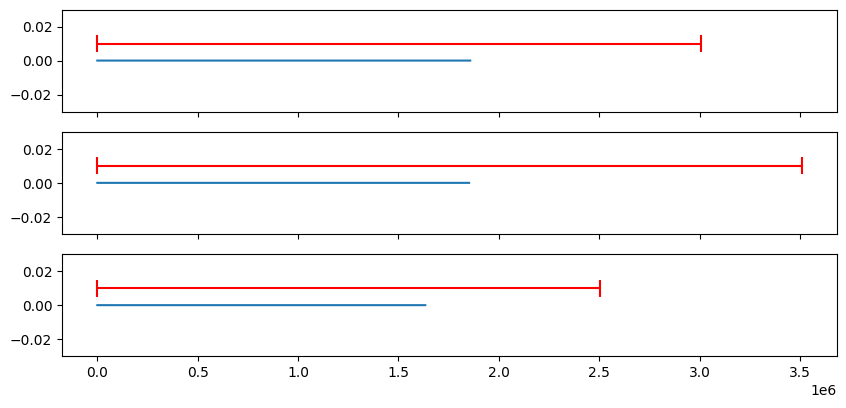

In [53]:
results = glob('/home/jake/genome-sim-benchmark/results-simulome/num-snps-num-genes/*/5-2000/results-simulome_mutations.log')[0:10]
print(results)
fig, axes = plt.subplots(nrows=len(results), ncols=1, figsize=(10,1.5*len(results)), sharex=True)
for idx, result in enumerate(results):
    df = pd.read_csv(result, sep='\t')
    print(df.head(3).to_markdown(index=False))
    accession = [x for x in result.split('/') if 'GCF' in x][0]
    print(result, accession)
    ax = axes[idx]
    ax.plot(df['START'], [0] * len(df))
    ax.hlines(0.01, 0, helpers.get_assembly_length(accession), colors='r')
    ax.vlines([0, helpers.get_assembly_length(accession)], 0.005, 0.015, colors='r')
    ax.set_ylim(ymin=-0.03, ymax=0.03)
#ax.legend()
plt.show()

#### featureCounts data

['/home/jake/genome-sim-benchmark/results-simulome/num-snps-num-genes/GCF_018394055.1/3-1500/results-simulome_mutations.log.featureCounts', '/home/jake/genome-sim-benchmark/results-simulome/num-snps-num-genes/GCF_006337105.1/3-1500/results-simulome_mutations.log.featureCounts', '/home/jake/genome-sim-benchmark/results-simulome/num-snps-num-genes/GCF_002157895.1/3-1500/results-simulome_mutations.log.featureCounts', '/home/jake/genome-sim-benchmark/results-simulome/num-snps-num-genes/GCF_002208805.2/3-1500/results-simulome_mutations.log.featureCounts', '/home/jake/genome-sim-benchmark/results-simulome/num-snps-num-genes/GCF_003627135.1/3-1500/results-simulome_mutations.log.featureCounts']


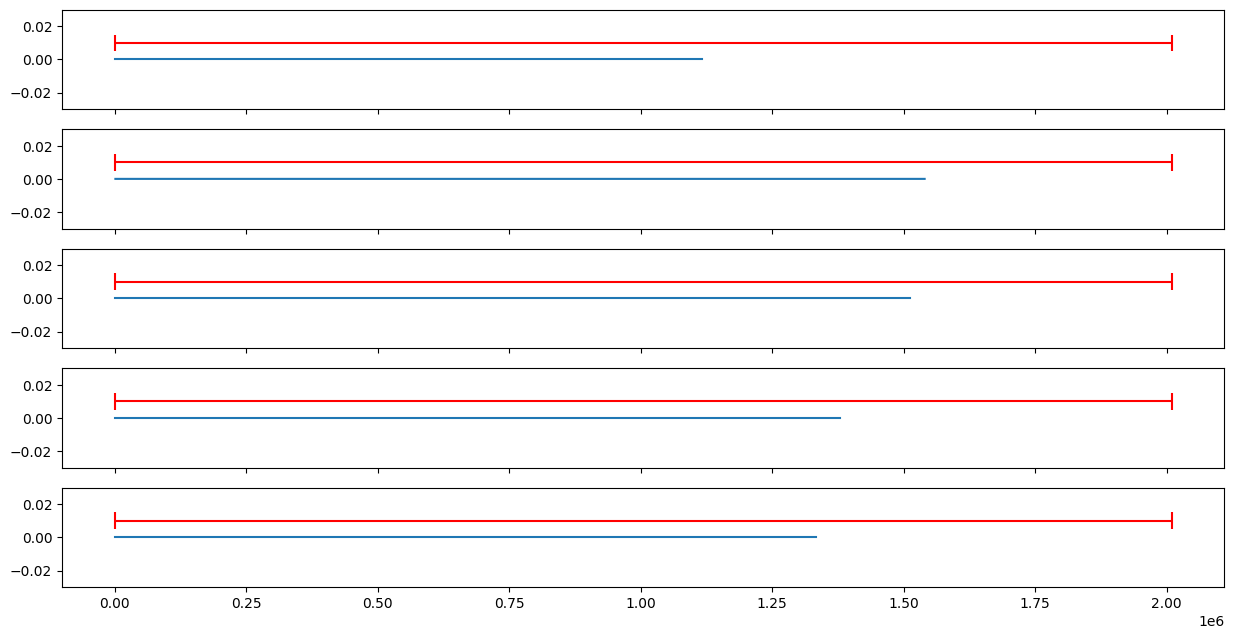

In [69]:
results = glob('/home/jake/genome-sim-benchmark/results-simulome/num-snps-num-genes/*/3-1500/results-simulome_mutations.log.featureCounts')[0:10]
print(results)
fig, axes = plt.subplots(nrows=len(results), ncols=1, figsize=(15,1.5*len(results)), sharex=True)
for idx, result in enumerate(results):
    df = pd.read_csv(result, sep='\t', comment='#', skiprows=2, names='Geneid	Chr	Start	End	Strand	Length	Count'.split('\t'))
    df['Start'] = pd.to_numeric(df['Start'])
    ax = axes[idx]
    ax.plot(df[df['Count'] > 0]['Start'], [0] * len(df[df['Count'] > 0]))
    ax.hlines(0.01, 0, helpers.get_assembly_length(accession), colors='r')
    ax.vlines([0, helpers.get_assembly_length(accession)], 0.005, 0.015, colors='r')
    ax.set_ylim(ymin=-0.03, ymax=0.03)
    
#ax.legend()
plt.show()

In [67]:
df[df['Count'] > 0]['Start'].max()

473020